# test--节点插入、删除

value2
{'key': 'value'}
{'key': 'value2'}
{}


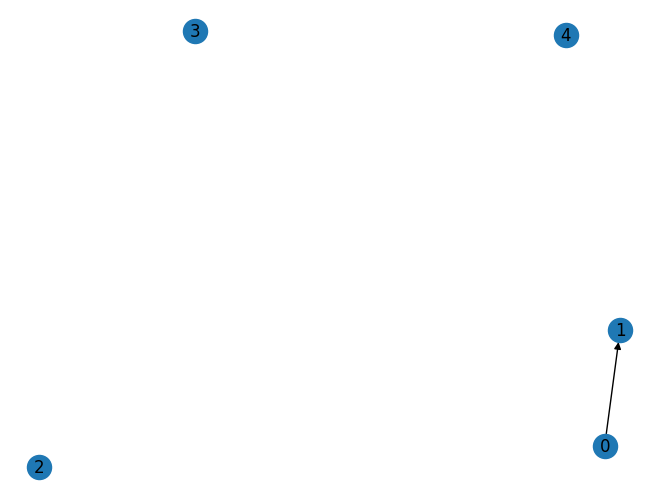

In [39]:
#添加节点
 
import networkx as nx
import matplotlib.pyplot as plt
 
G1 = nx.DiGraph()     
# G1.add_node(1,key = "value")            #建立一个空的无向图G
G1.add_nodes_from([(1,{"key":"value"}),(2, {"key":"value2"}),3])                  #添加一个节点1
G1.add_edges_from([(1,2)])
G1.nodes[1]['key']
for node_index in G1.successors(1):
    print(G1.nodes[node_index]['key'])

G2 = nx.DiGraph()
G2.add_nodes_from([1,2])
G = nx.disjoint_union(G1, G2)

for node, node_data in G1.nodes.items():
    print(node_data)

nx.draw(G, with_labels=True)
plt.show()


# test--后继节点、子图

Direct successors of 'A': ['D', 'E', 'C', 'B']
Subgraph nodes: ['A', 'B', 'D']
Subgraph edges: [('A', 'B'), ('B', 'D')]


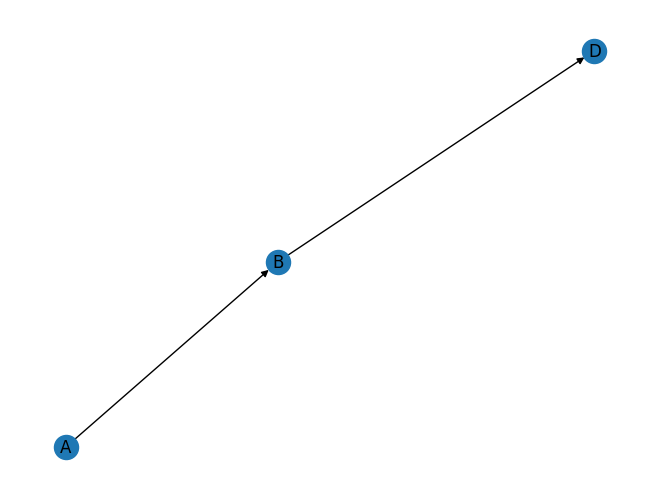

In [8]:
import networkx as nx

# 创建有向图
G = nx.DiGraph()

# 添加边
edges = [
    ('A', 'B'),
    ('A', 'C'),
    ('B', 'D'),
    ('C', 'D'),
    ('C', 'E'),
    ('D', 'E')
]

G.add_edges_from(edges)

# nx.draw(G, with_labels=True)

# 指定起始节点
start_node = 'A'

# 获取所有直接后继节
successors = list(nx.descendants(G, 'A'))
print("Direct successors of '{}': {}".format(start_node, successors))

# 创建子图的节点列表（包括起始节点和其后继）
subgraph_nodes = [start_node] + successors

# 生成子图
H = G.subgraph(subgraph_nodes)

G.remove_nodes_from(["E", "C"])


# 打印子图的节点和边
print("Subgraph nodes:", G.nodes())
print("Subgraph edges:", G.edges())

# 可视化子图（可选）
nx.draw(G, with_labels=True)

# test--nextworkx转化为pyg

In [ ]:
import networkx as nx
import torch
from torch_geometric.data import Data

def convert_nx_to_pyg(G):
    # 获取所有节点并排序，确保顺序一致
    nodes = list(G.nodes())
    node_idx = {node: idx for idx, node in enumerate(nodes)}

    # 生成节点特征（例如，每个节点一个特征值为1）
    n_nodes = len(nodes)
    x = torch.ones(n_nodes, 1, dtype=torch.float32)
    print(x)
    # 处理边信息
    edges = list(G.edges())
    sources = [node_idx[e[0]] for e in edges]
    targets = [node_idx[e[1]] for e in edges]

    edge_index = torch.tensor([sources, targets], dtype=torch.long)

    return Data(x=x, edge_index=edge_index)

# 创建示例图
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 2)])

# 转换图
data = convert_nx_to_pyg(G)


print(data)

tensor([[1.],
        [1.],
        [1.]])
Data(x=[3, 1], edge_index=[2, 2])


# test--自定义环境(继承gym.Env) + DQN + RlLib(强化学习框架)

In [3]:

import gymnasium
from gymnasium import spaces
import numpy as np
import random

class CustomEnv(gymnasium.Env):
    metadata = {'render.modes': ['console']}

    def __init__(self, seed=None):
        super().__init__()
        self.n_actions = 2  # 动作空间的维度
        self.n_states = 3   # 状态空间的维度
        self.action_space = spaces.Discrete(self.n_actions)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.n_states,), dtype=np.float32)

        self._seed = seed
        if self._seed is not None:
            random.seed(self._seed)
            np.random.seed(self._seed)

    def reset(self):
        # Reset the environment and return the initial state
        self.state = np.array([np.random.uniform(-1, 1) for _ in range(self.n_states)])
        return self.state

    def step(self, action):
        # Execute one step in the environment
        reward = random.uniform(0, 1)
        done = False  # Episodes are not terminal by default
        next_state = np.array([np.random.uniform(-1, 1) for _ in range(self.n_states)])

        return next_state, reward, done, {}

    def render(self, mode='console'):
        print(f"Current state: {self.state}")

    def close(self):
        pass

    def is_continuous(self):
        return False

    def is_discrete(self):
        return True

    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

### DQN算法实现部分（使用PyTorch）


import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQN_Agent:
    def __init__(self, env, batch_size=32, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=10000):
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        input_size = env.observation_space.shape[0]
        output_size = env.action_space.n
        self.model = DQN(input_size, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        self.memory = deque(maxlen=10000)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.env.action_space.n - 1)

        with torch.no_grad():
            q_values = self.model(torch.FloatTensor(state))
            return q_values.argmax().item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([t[0] for t in minibatch])
        actions = np.array([t[1] for t in minibatch]).astype(np.int64)
        rewards = np.array([t[2] for t in minibatch]).astype(np.float32)
        next_states = np.array([t[3] for t in minibatch])
        dones = np.array([t[4] for t in minibatch]).astype(bool)

        # Convert to tensors
        states_t = torch.FloatTensor(states)
        actions_t = actions.long()
        rewards_t = rewards.unsqueeze(1)  # 增加一个维度，方便后续计算
        next_states_t = torch.FloatTensor(next_states)
        dones_t = dones.float().unsqueeze(1)

        current_q_values = self.model(states_t).gather(dim=1, index=actions_t.unsqueeze(1))

        with torch.no_grad():
            next_q_values = self.model(next_states_t).max(dim=1)[0].detach()

        target_q_values = rewards_t + (1 - dones_t) * self.gamma * next_q_values.unsqueeze(1)

        loss = self.criterion(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon_decay / (self.epsilon_decay + np.exp(-self.epsilon)))

### 使用RLlib整合代码


import ray
from ray import tune
from ray.tune.registry import register_env
from ray.rllib.env import BaseEnv

# 将自定义环境注册到Ray/RLLib
def env_creator(env_config):
    return CustomEnv()

register_env("CustomEnv-v0", env_creator)

# DQN模型的配置
config = {
    "env": "CustomEnv-v0",
    "num_workers": 3,
    "gamma": 0.99,
    "learning_rate": 0.001,
    "buffer_size": 10000,
    "batch_size": 32,
    "epsilon_start": 1.0,
    "epsilon_end": 0.01,
    "epsilon_decay": 10000,
}

ray.init()

# 启动训练过程
tune.run(
    "DQN",
    config=config,
    stop={"episode_reward_mean": 500},
)

ray.shutdown()

2025-02-14 09:59:49,469	INFO worker.py:1841 -- Started a local Ray instance.
2025-02-14 09:59:50,425	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-02-14 09:59:50,443	WARNING algorithm_config.py:4726 -- You are running DQN on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-02-14 09:59:50,444	WARNING algorithm_config.py:4726 -- You are running DQN on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
(pid=34900) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(DQN pid=34900) 2025-02-

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: a7277ab932301c8614c5917b2e11662ffab04fb5d2a2b514048ec028 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 26118 Worker PID: 35037 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1.


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:00:59,169	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(DQN pid=34900) 2025-02-14 09:59:58,242	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future! [repeated 3x across cluster]
(SingleAgentEnvRunner pid=35037) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeat

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: 5ef67aa513d4d4f93ba836981ad094cbdf14dd72d9b9313af2228f34 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 10729 Worker PID: 36439 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:02:06,461	ERROR actor_manager.py:815 -- Ray error (The actor e714c762e5b6504c5ec14c0d01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 1 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:02:06,461	ERROR actor_manager.py:815 -- Ray error (The actor 7c669962a10c460863c7229c01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 2 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:02:06,461	ERROR actor_manager.py:815 -- Ray error (The actor 5a53efdf420527e542a1f58e01000000 is unavailable: The actor is

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: d7a22fde68cfd3ed649c02563cf64124d81bc6f551c796ee806ea41d Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 31367 Worker PID: 37662 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:03:10,470	ERROR actor_manager.py:815 -- Ray error (The actor e714c762e5b6504c5ec14c0d01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 1 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:03:10,470	ERROR actor_manager.py:815 -- Ray error (The actor 7c669962a10c460863c7229c01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 2 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:03:10,470	ERROR actor_manager.py:815 -- Ray error (The actor 5a53efdf420527e542a1f58e01000000 is unavailable: The actor is

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: a5afbe94be16f3ce67210d6447a65000ed8a65174b3b56f723cfd0f6 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 33585 Worker PID: 38923 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:04:12,488	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=38922) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=38922) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=38922)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=38922) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: 7d521623678ef5a150dfab1c3eb58e4d418350ce839d92a30df5ae49 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 28264 Worker PID: 40150 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:05:16,496	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=40149) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=40149) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=40149)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=40149) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: 47354d8261ac8bcaf0cf8b7a0088ecd966cb92abdedfd63dc3bfb535 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 36708 Worker PID: 41242 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:06:22,495	ERROR actor_manager.py:815 -- Ray error (The actor e714c762e5b6504c5ec14c0d01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 1 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:06:22,496	ERROR actor_manager.py:815 -- Ray error (The actor 7c669962a10c460863c7229c01000000 is unavailable: The actor is temporarily unavailable: RpcError: RPC Error message: Cancelling all calls; RPC Error details: . The task may or maynot have been executed on the actor.), taking actor 2 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:06:22,496	ERROR actor_manager.py:815 -- Ray error (The actor 5a53efdf420527e542a1f58e01000000 is unavailable: T

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff7c669962a10c460863c7229c01000000 Worker ID: 8443272f76022987cf227401bcdc0d538f0476f7d4a0dc02f4db1eb0 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 11942 Worker PID: 42396 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:07:24,514	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=42396) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=42396) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=42396)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=42396) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: 249f851cc279d3e943389c3728560611ced62b5addba96b4b2397e2b Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 22493 Worker PID: 43606 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:08:28,523	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=43605) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=43604) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=43604)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=43604) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: 5218125dc9b298d5c2778043e0dd808f94b139f62a7b13506f527b03 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 29905 Worker PID: 44767 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:09:32,532	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=44767) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=44767) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=44767)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=44767) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: 4669a199656d83527259bb10707a2138ba99af593ba528754e3f84ba Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 30943 Worker PID: 45887 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:10:36,540	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=45887) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=45887) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=45887)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=45887) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: b7118d7f1aae3fbf366677981d6e234e3420f8675b00cce6eb3d2b72 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 14141 Worker PID: 47097 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:11:40,548	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=47097) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=47097) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=47097)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=47097) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: ac65c1da51714d51090f3f7ce1d4f6ca251ddb9bf4edc4c2de2ce531 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 10445 Worker PID: 48295 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:12:44,559	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=48293) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=48293) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=48293)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=48293) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: 4f3982e098a1fb96efa285f248d2b147ca185b3c6ce46caa73351e5d Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 22975 Worker PID: 49482 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:13:48,568	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=49482) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=49482) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=49482)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=49482) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff7c669962a10c460863c7229c01000000 Worker ID: e6ee381bebd517f2dd06813eabfeae86f2d3e05de145268f2ac305b2 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 19454 Worker PID: 50639 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:14:54,568	ERROR actor_manager.py:815 -- Ray error (The actor e714c762e5b6504c5ec14c0d01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 1 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:14:54,568	ERROR actor_manager.py:815 -- Ray error (The actor 7c669962a10c460863c7229c01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 2 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:14:54,568	ERROR actor_manager.py:815 -- Ray error (The actor 5a53efdf420527e542a1f58e01000000 is unavailable: The actor is

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: 94d79a6be5cf806aa07e8ae23a53eaf9623463dd0b623bcb6b06c1d9 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 12146 Worker PID: 52032 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:15:56,586	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=52030) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=52030) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=52030)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=52030) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: 17e7458f38eb0ea1075e38a3bcbe7e1eaae40831e229ecfdb446fc58 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 27299 Worker PID: 53278 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:17:02,588	ERROR actor_manager.py:815 -- Ray error (The actor e714c762e5b6504c5ec14c0d01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 1 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:17:02,588	ERROR actor_manager.py:815 -- Ray error (The actor 7c669962a10c460863c7229c01000000 is unavailable: The actor is temporarily unavailable: RpcError: RPC Error message: Cancelling all calls; RPC Error details: . The task may or maynot have been executed on the actor.), taking actor 2 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:17:02,588	ERROR actor_manager.py:815 -- Ray error (The actor 5a53efdf420527e542a1f58e01000000 is unavailable: T

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff7c669962a10c460863c7229c01000000 Worker ID: 7caa363a18c1897ff15224680c4e41a00982b2fcd0d550e4b8334814 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 32405 Worker PID: 53276 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 2x across cluster]


# test--numpy

In [22]:
import numpy as np
v1 = np.zeros((0,2))
v2 = np.array([3,4]).reshape(1,-1)
v3 = np.array([5, 6]).reshape(1,-1)
v = np.vstack((v1, v2,v3))
print(v)

[[3. 4.]
 [5. 6.]]


# test--Pytorch

In [3]:
import torch
torch.cuda.device_count()
v1 = torch.Tensor([1,2])
v2 = torch.Tensor([3,4])
v = torch.concatenate((v1,v2))
print(v.shape)

torch.Size([4])


# test--强化学习

In [8]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
# 在代码开头添加以下导入语句
import torch.nn.functional as F  # PyTorch场景

# 环境定义（4x4网格世界）
class GridWorld:
    def __init__(self):
        self.size = 4
        self.goal = (3, 3)
        self.obstacles = [(1, 1), (2, 2)]
        self.reset()
        
    def reset(self):
        self.pos = (0, 0)
        return self.get_state()
    
    def get_state(self):
        return np.array(self.pos)
    
    def get_mask(self):
        x, y = self.pos
        mask = [1, 1, 1, 1]  # 上下左右
        
        # 边界检测
        if x == 0: mask[0] = 0       # 不能向上
        if x == self.size-1: mask[1] = 0  # 不能向下
        if y == 0: mask[3] = 0       # 不能向左
        if y == self.size-1: mask[2] = 0  # 不能向右
        
        # 障碍物检测
        for (ox, oy) in self.obstacles:
            if (x-1, y) == (ox, oy): mask[0] = 0  # 上方障碍
            if (x+1, y) == (ox, oy): mask[1] = 0  # 下方障碍
            if (x, y+1) == (ox, oy): mask[2] = 0  # 右方障碍
            if (x, y-1) == (ox, oy): mask[3] = 0  # 左方障碍
            
        return np.array(mask)
    
    def step(self, action):
        x, y = self.pos
        reward = 0
        done = False
        
        # 执行动作（带有效性验证）
        if self.get_mask()[action]:
            if action == 0: new_pos = (x-1, y)
            elif action == 1: new_pos = (x+1, y)
            elif action == 2: new_pos = (x, y+1)
            else: new_pos = (x, y-1)
            
            # 碰撞检测
            if new_pos in self.obstacles:
                reward = -1  # 碰撞惩罚
            else:
                self.pos = new_pos
                
            # 目标检测（稀疏奖励）
            if self.pos == self.goal:
                reward = 10
                done = True
                
        return self.get_state(), reward, done

# DQN网络
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
        
    def forward(self, x):
        return self.fc(x)

# 带掩码的DQN智能体
class MaskedDQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_dim = 2
        self.action_dim = 4
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 32
        self.memory = deque(maxlen=10000)
        
        self.policy_net = DQN(self.state_dim, self.action_dim)
        self.target_net = DQN(self.state_dim, self.action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        
    def choose_action(self, state, mask):
        state = torch.FloatTensor(state)
        if np.random.random() < self.epsilon:
            valid_actions = np.where(mask == 1)[0]
            return np.random.choice(valid_actions)
        else:
            with torch.no_grad():
                q_values = self.policy_net(state)
                # 应用掩码
                q_values = torch.where(torch.BoolTensor(mask), q_values, torch.tensor(-np.inf))
                return torch.argmax(q_values).item()
    
    def store_transition(self, state, action, reward, next_state, done, next_mask):
        self.memory.append((state, action, reward, next_state, done, next_mask))
        
    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones, next_masks = zip(*batch)
        
        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.BoolTensor(dones)
        
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # 带掩码的下一状态Q值计算
        next_q = torch.zeros(self.batch_size)
        valid_next_states = next_states[~dones]
        valid_masks = [m for m, d in zip(next_masks, dones) if not d]
        
        if len(valid_next_states) > 0:
            with torch.no_grad():
                next_q_values = self.target_net(valid_next_states)
                # 应用下一状态掩码
                masked_q = [torch.where(torch.BoolTensor(m), q, torch.tensor(-np.inf)) 
                           for m, q in zip(valid_masks, next_q_values)]
                max_next_q = torch.stack([q.max() for q in masked_q])
                next_q[~dones] = max_next_q
        
        target_q = rewards + self.gamma * next_q
        
        loss = F.mse_loss(current_q.squeeze(), target_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Epsilon衰减
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 训练流程
env = GridWorld()
agent = MaskedDQNAgent(env)
episodes = 20

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        mask = env.get_mask()
        action = agent.choose_action(state, mask)
        next_state, reward, done = env.step(action)
        next_mask = env.get_mask() if not done else np.zeros(4)
        
        agent.store_transition(state, action, reward, next_state, done, next_mask)
        agent.train()
        
        state = next_state
        total_reward += reward
        
    if ep % 1 == 0:
        agent.update_target()
        print(f"Episode: {ep}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# 测试演示
test_env = GridWorld()
state = test_env.reset()
done = False

print("\nTest Trajectory:")
while not done:
    mask = test_env.get_mask()
    action = agent.choose_action(state, mask)
    next_state, reward, done = test_env.step(action)
    print(f"Position: {state} -> Action: {['Up','Down','Right','Left'][action]} -> New Position: {next_state}")
    state = next_state

Episode: 0, Total Reward: 10, Epsilon: 0.90
Episode: 1, Total Reward: 10, Epsilon: 0.83
Episode: 2, Total Reward: 10, Epsilon: 0.78
Episode: 3, Total Reward: 10, Epsilon: 0.70
Episode: 4, Total Reward: 10, Epsilon: 0.61
Episode: 5, Total Reward: 10, Epsilon: 0.58
Episode: 6, Total Reward: 10, Epsilon: 0.47
Episode: 7, Total Reward: 10, Epsilon: 0.45
Episode: 8, Total Reward: 10, Epsilon: 0.42
Episode: 9, Total Reward: 10, Epsilon: 0.40
Episode: 10, Total Reward: 10, Epsilon: 0.38
Episode: 11, Total Reward: 10, Epsilon: 0.37
Episode: 12, Total Reward: 10, Epsilon: 0.36
Episode: 13, Total Reward: 10, Epsilon: 0.34
Episode: 14, Total Reward: 10, Epsilon: 0.33
Episode: 15, Total Reward: 10, Epsilon: 0.31
Episode: 16, Total Reward: 10, Epsilon: 0.30
Episode: 17, Total Reward: 10, Epsilon: 0.29
Episode: 18, Total Reward: 10, Epsilon: 0.28
Episode: 19, Total Reward: 10, Epsilon: 0.25

Test Trajectory:
Position: [0 0] -> Action: Right -> New Position: [0 1]
Position: [0 1] -> Action: Right -> 

# test--其他

In [ ]:
d = {'key':'value'}
list(d.values())[0]
col = 't.title'
ans = col.split('.')
print(ans)
ans = set()
ans.add(('alias', 'col'))
ans.add(('alias', 'col'))
print(ans)
a = [(1,2),(3,4)]
for b,c in a:
    print(b)
    print(c)
a = '123'
a = a[:-1]
print(a)
a = [1,2,3]
b = []

print(b)
a,b = '1','2'
print(a)

['t', 'title']
{('alias', 'col')}
1
2
3
4
12
[]


ValueError: not enough values to unpack (expected 2, got 1)